In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  9 14:12:53 2017

@author: charles
"""

import pickle
import numpy as np

import numpy as np
import sklearn
from scipy.stats import chi2 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

### read and normalize data

In [2]:
X = np.load('../data/excellent_unoriented/obs.npy')
X /= X.max(axis=0)
y = pickle.load( open( "../data/excellent_unoriented/labels.pkl", "rb" ) )
y = np.array(y)
nsamples, nfeatures = X.shape

-0.33042782728267744 1.0


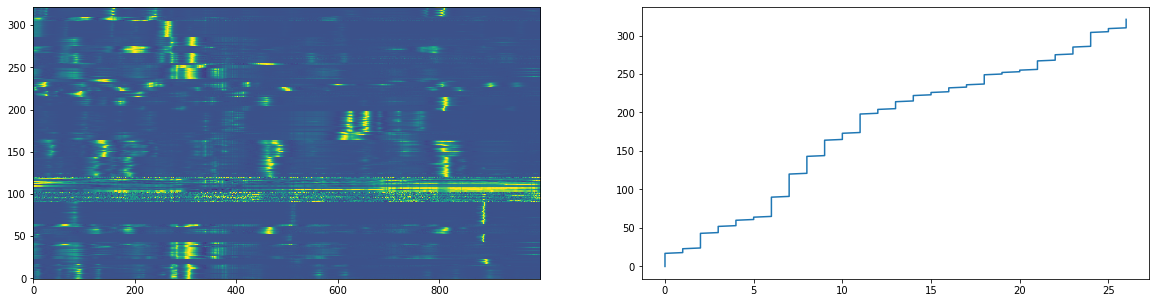

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.imshow(X, origin='lower', aspect='auto')
ax2.plot(y, list(range(len(y))))
print(X.min(), X.max())

### compute mean spectra and variances

In [4]:
nlabels = len(np.unique(y))
print(nlabels)

27


In [5]:
mean_spectra = np.vstack([ np.mean(X[iclass==y], axis=0) for iclass in range(nlabels) ])
var_spectra = np.vstack([ np.var(X[iclass==y], axis=0) for iclass in range(nlabels) ])

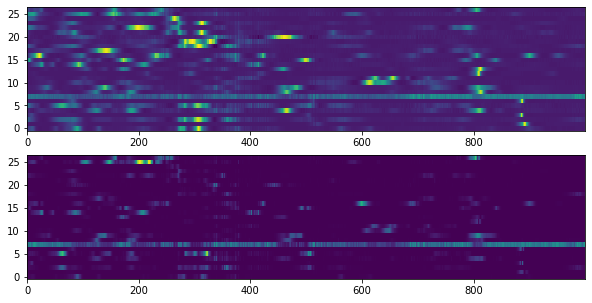

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.imshow(mean_spectra, origin='lower', aspect='auto')
ax2.imshow(var_spectra, origin='lower', aspect='auto')

### prepare synthetic data

In [7]:
nsynt = 10
synt_y = np.random.binomial(1, p=3./27., size=(nsynt, nlabels))

In [8]:
synt_X = np.zeros((nsynt, nfeatures))

for isample, mixture in enumerate(synt_y):
    for iclass, weight in enumerate(mixture):
        class_spectra = X[np.array(y) == iclass]
        ispec = np.random.choice(len(class_spectra))
        synt_X[isample] += weight * class_spectra[ispec]

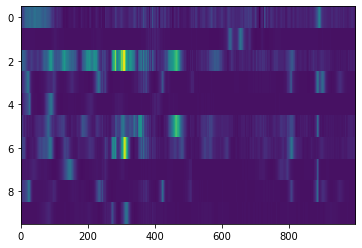

In [9]:
plt.figure()
plt.imshow(synt_X, aspect='auto')

(1000,)


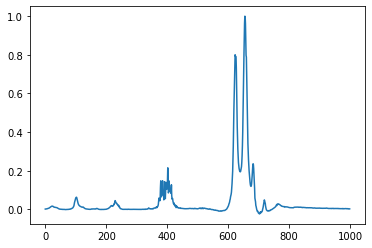

In [198]:
observation = synt_X[1]
mix = synt_y[1]
print(observation.shape)
plt.plot(observation)

### likelihood model

In [199]:
import theano.tensor as tt
import pymc3 as pm
from theano.compile.ops import as_op

def logp(params):
    likelihood = -(observation - pm.math.sum(params[:, None] * mean_spectra, axis=0))**2/(0.5 * var_spectra)
    return likelihood

In [200]:
with pm.Model() as model:
    params = pm.Binomial('params', n=1, p=0.5, shape=27)
    like = pm.Potential('like', logp(params))
    step = pm.BinaryGibbsMetropolis([params])
    trace = pm.sample(100, cores=10, step=step)

Only 100 samples in chain.
Multiprocess sampling (10 chains in 10 jobs)
BinaryGibbsMetropolis: [params]
Sampling 10 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1117.68draws/s]


In [201]:
trace.get_values('params')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

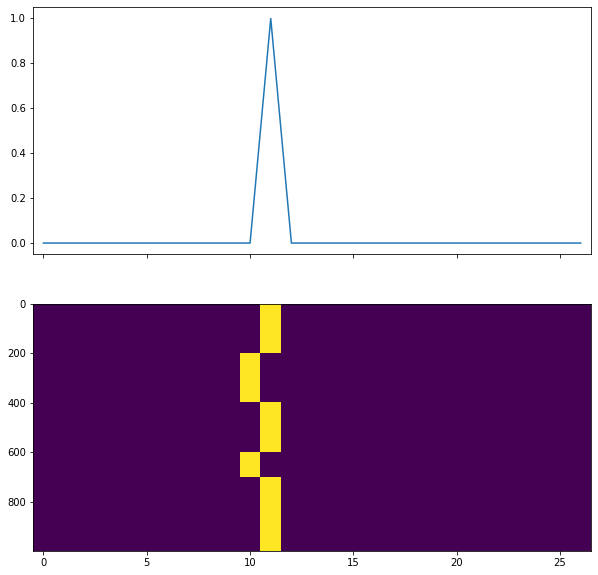

In [202]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.plot(mix)
ax2.imshow(trace.get_values('params'), aspect='auto')